# Lecture 25: Logistic Regression 
***

We'll need Numpy, Matplotlib, Pandas, and scipy.stats for this notebook, so let's load them. 

In [1]:
import numpy as np 
from scipy import stats
import statsmodels.api as sm 
import pandas as pd
import matplotlib.pylab as plt 
%matplotlib inline

/Users/cketelsen/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Exercise 1 - Exploring the Sigmoid Function 
*** 

The following routine plots the sigmoid function of the form $\textrm{sigm}(\beta_0 + \beta_1 x)$ for different values of the parameters $\beta_0$ and $\beta_1$.  Your job in this exercise is to play with the parameters $\beta_0$ and $\beta_1$ and figure out how they affect the shape of the model.  We recommend starting out with the intercept at zero and playing with the slope parameter.  Then set the slope parameter back to $1$ and playing with the intercept parameter.  Then try varying both parameters at the same time. 

In [32]:
def sigm(z):
    return 1 / (1 + np.exp(-z))

def plot_model(b0, b1):
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,6))
    
    x = np.linspace(-20,20,200)
    p = sigm(b0 + b1*x)
    
    ax.plot(x, p, color="steelblue", lw=3)
    ax.grid(alpha=0.25)
    ax.set_xlim([-20, 20])
    ax.set_xlabel("x", fontsize=20)
    ax.set_ylabel(r"sigm$(\beta_0 + \beta_1 x)$", fontsize=20)
    plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0])

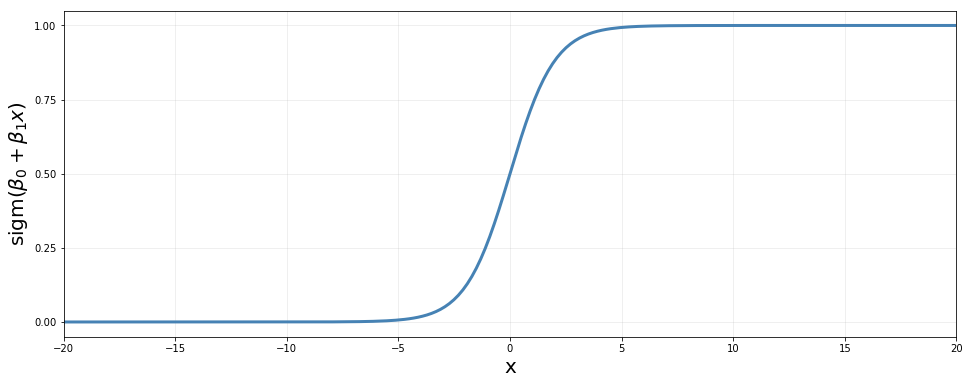

In [82]:
plot_model(0,1)

### Exercise 2 - Determining the Model Parameters 
*** 

Suppose you have the following labeled data relating tumor size to life/death outcome.  Here the feature $x$  represents the size of the tumor in centimeters and the response $y = \{0,1\} = $ {alive, dead}.   

In [62]:
dfC = pd.DataFrame({"y": np.array([0]*4 + [1]*4) , "x": np.hstack((np.linspace(.5,1.5,4), np.linspace(2.1, 3.1, 4)))})
dfC = dfC.loc[:,["y", "x"]]
dfC.head(10)

,y,x
0,0,0.500000
1,0,0.833333
2,0,1.166667
3,0,1.500000
4,1,2.100000
5,1,2.433333
6,1,2.766667
7,1,3.100000


**Part A**: The following function plots the Logistic Regression model for the given parameters against the data.  Your job is to find parameters $\beta_0$ and $\beta_1$ so that the model accurately classifies all points in the dataset. 

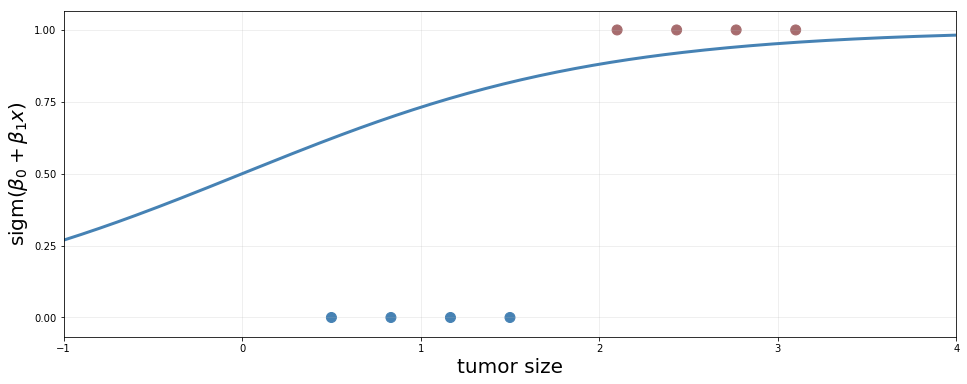

In [110]:
def check_model(df, b0, b1):
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,6))
    
    x = np.linspace(-1,4,200)
    p = sigm(b0 + b1*x)
    
    ax.plot(x, p, color="steelblue", lw=3)
    ax.grid(alpha=0.25)
    ax.set_xlim([-1, 4])
    ax.set_xlabel("tumor size", fontsize=20)
    ax.set_ylabel(r"sigm$(\beta_0 + \beta_1 x)$", fontsize=20)
    plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0])
    
    x, y = df["x"], df["y"]
    
    colors = ["steelblue" if yval==0 else "#a76c6e" for yval in y]
    ax.scatter(x, y, color=colors, s=100)
    
check_model(dfC, 0, 1)

**Part B**: There are several methods in Python we can use to determine the parameters in the Logistic Regression model.  We'll use the [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) method that is part of [Scikit Learn](http://scikit-learn.org/). The following code fits a Logistic Regression model to the cancer data.  Plug the resulting coefficients into the check_model function to see the results. 

In [79]:
from sklearn.linear_model import LogisticRegression

In [129]:
# Extract response vector and feature matrix from the DataFrame.  Note that the function 
# expects X to be a matrix, which is why we need the reshape function.
y, X = dfC["y"], dfC["x"].values.reshape(-1,1)

# Initialize the LogisticRegression method with parameters 
logreg = LogisticRegression(fit_intercept=True, C=1000)

# Fit the model to the data 
logreg.fit(X, y)

# Extract and print the parameters 
b0 = logreg.intercept_[0]
b1 = logreg.coef_[0][0]
print("intercept = {:.3f}, slope = {:.3f}".format(b0, b1))

intercept = -16.557, slope = 9.278


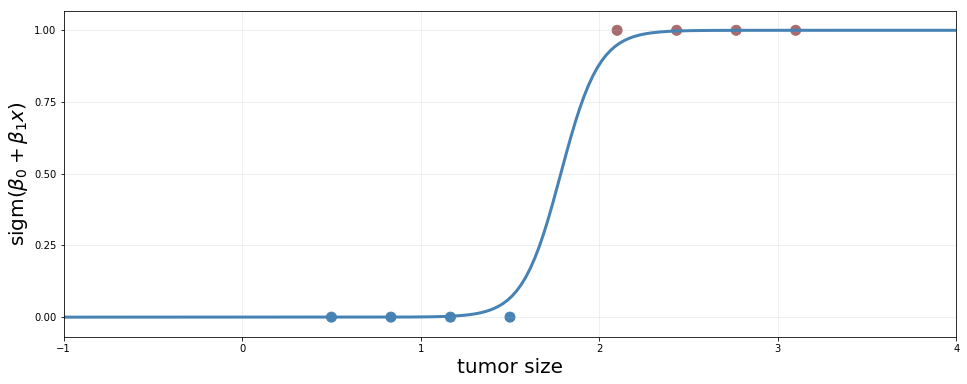

In [130]:
check_model(dfC, b0, b1)

**Part C**: Suppose we want to use our model to make a prediction about the outcome for a patient with an initial tumor of size $x = 1.95$. Use the learned parameters and the sigmoid function to estimate $p(y=1 \mid x=1.95)$. 

In [126]:
print("p(y=1 | x=1.95) = {:.5f}".format(sigm(b0+b1*1.95)))

p(y=1 | x=1.95) = 0.82267


**Part D**: The following commands perform prediction using the sklearn model we've learned.  Can you figure out the different behaviors of the two methods? 

In [128]:
print("? = {}".format(logreg.predict(1.95)))
print("? = {}".format(logreg.predict_proba(1.95)))

? = [1]
? = [[ 0.17733351  0.82266649]]


### Exercise 3 - Logistic Regression with Multiple Features 
*** 

In this problem we'll look at logistic regression for 2D continuous data. The data we'll use are <a href="https://www.math.umd.edu/~petersd/666/html/iris_with_labels.jpg">sepal</a> measurements from the ubiquitous [*iris* dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set). This dataset includes sepal and petal measurements from three species of iris.  The goal is to predict the specific species of iris from the features.  We'll look at just the sepal length and width in centimeters and restrict ourselves to the Iris Virginica and Iris Versicolor species.   


<!---
<img style="float:left; width:450px" src="https://upload.wikimedia.org/wikipedia/commons/9/9f/Iris_virginica.jpg",width=300,height=50>
-->

<img style="float:left; width:450px" src="http://www.twofrog.com/images/iris38a.jpg",width=300,height=50>

<!---
<img style="float:right; width:490px" src="https://upload.wikimedia.org/wikipedia/commons/4/41/Iris_versicolor_3.jpg",width=300,height=50>
-->

<img style="float:right; width:490px" src="http://blazingstargardens.com/wp-content/uploads/2016/02/Iris-versicolor-Blue-Flag-Iris1.jpg",width=300,height=62>


The iris dataset is actually built into sklearn.  In the following code we load in the data, restrict ourselves to two species and the first two features, and plot the results. 

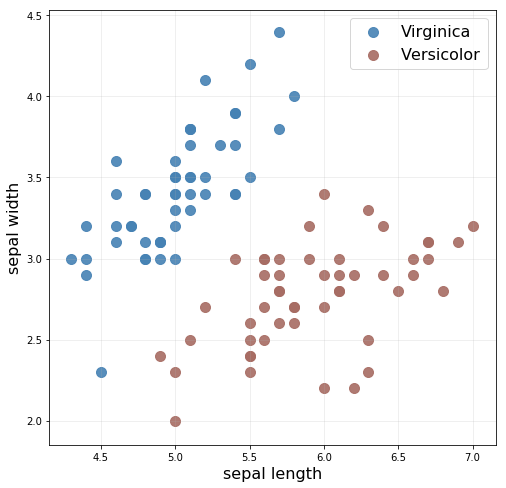

In [141]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data[iris.target != 2, :2] # first two features and
y = iris.target[iris.target != 2]   # first two labels only 

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
ax.scatter(X[y==0, 0], X[y==0, 1], s=100, alpha=0.9, c="steelblue", label="Virginica")
ax.scatter(X[y==1, 0], X[y==1, 1], s=100, alpha=0.9, c="#a76c63", label="Versicolor")
ax.legend(loc="upper right", fontsize=16)
ax.set_xlabel('sepal length', fontsize=16)
ax.set_ylabel('sepal width', fontsize=16);
ax.grid(alpha=0.25)

**Part A**: Use the data and sklearn to fit a Logistic Regression model to the iris data. What are the parameters $\beta_0$, $\beta_1$, and $\beta_2$? 

In [146]:
logreg = LogisticRegression(fit_intercept=True)
logreg.fit(X, y)
b0 = logreg.intercept_[0]
b1, b2 = logreg.coef_[0][0], logreg.coef_[0][1]
print("beta_0 = {:.5f}".format(b0))
print("beta_1 = {:.5f}".format(b1))
print("beta_2 = {:.5f}".format(b2))

beta_0 = -0.59901
beta_1 = 2.21657
beta_2 = -3.69152


**Part B**: Recall that the decision rule for Logistic Regression is to predict $\hat{y}=1$ if 

$$
\textrm{sigm}(\hat{\beta}_0 + \hat{\beta}_1 x_1 + \hat{\beta}_2 x_2) \geq 0.5 
$$

The points where $\textrm{sigm}(z)$ is exactly equal to $0.5$ is called the decision boundary.  For Logistic Regression the decision boundary is a line in two-dimensional space such that everything on one side of the line is predicted to be from Class $0$ and everything on the other side of the line is predicted to be from Class $1$.  Your job in this exercise is to figure out the equation of the decision boundary and then plot it on the figure above. 

**Hint**: Think about $x_1$ as $x$ and $x_2$ as $y$. 

**Solution**: The sigmoid function is equal to $0.5$ when it's argument is equal to $0$.  We then have 

$$
\hat{\beta}_0 + \hat{\beta}_1 x_1 + \hat{\beta}_2 x_2 = 0 \quad \Rightarrow \quad x_2 = -\dfrac{\beta_0}{\beta_2}  -\dfrac{\beta_1}{\beta_2} x_1   
$$

This is the line of the form $y = mx + b$ with slope $m = - \beta_1 / \beta_2$ and intercept $b = -\beta_0 / \beta_2$. 

Plugging the computed values from the model into this formula we can plot the decision boundary. 

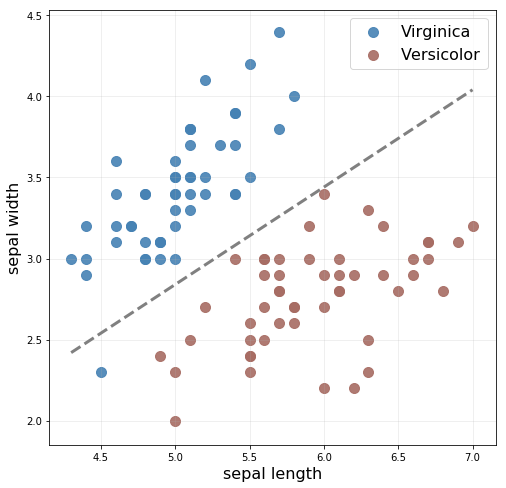

In [149]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
ax.scatter(X[y==0, 0], X[y==0, 1], s=100, alpha=0.9, c="steelblue", label="Virginica")
ax.scatter(X[y==1, 0], X[y==1, 1], s=100, alpha=0.9, c="#a76c63", label="Versicolor")
ax.legend(loc="upper right", fontsize=16)
ax.set_xlabel('sepal length', fontsize=16)
ax.set_ylabel('sepal width', fontsize=16);
ax.grid(alpha=0.25)

xx = np.linspace(np.min(X[:,0]),np.max(X[:,0]))
ax.plot(xx, -b0/b2 - b1/b2 * xx, color="gray", lw=3, ls="--");

**Part C**: Does the learned model accurately predict the species for each data point?  

**Solution**: Nope!  If you look in the lower-left corner you'll see that there is one blue point on the red side of the decision boundary. If you look hard at the data, you'll see that it's actually impossible to draw a linear decision boundary that perfectly separates the two classes.  This is not uncommon.  Almost all real data sets are like this.  Our goal in classification techniques is to learn a model that will accurately predict _most_ of the data that we use to train the parameters **AND** is likely to do a good job of making predictions on data that our model has never seen before.  